In [1]:
# Basic packages
import numpy as np
from matplotlib import pyplot as plt
import xarray as xr
import pandas as pd
import math
import netCDF4 as nc

# DateTime packages
from matplotlib.dates import DateFormatter
from datetime import datetime, timedelta
import time
import matplotlib.dates as mdates

# Stats packages
import scipy
import bottleneck as bn
import PyCO2SYS as pyco2
import gsw
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
import seaborn as sns

# Logistical packages
import requests
from importlib import reload
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.offsetbox import AnchoredText


In [1]:
import calc_coeffs

# function with `for` loop and `if` statements

In [123]:
def remove_outliers_cooks(X, Y):
    
    """
    This function calculates Cook's distance for both X and Y.
    Where Cook's distance is 3x the mean Cook's distance, the outlier is removed.
    
    Returns x and y arrays with outliers removed.
    """
    
    import numpy as np
    import statsmodels.api as sm
    
    # If X and Y are different length, print a warning and return.
    if not len(X) == len(Y):
        print('X and Y are not the same length.')
        return
    
    # Lazy way of checking if the inputs are numpy arrays
    # If not numpy arrays, make them numpy arrays
    if type(X) != type(np.arange(10)):
        x = X.to_numpy()
    else:
        x = X
    if type(Y) != type(np.arange(10)):
        y = Y.to_numpy()
    else: 
        y = Y
    
    # Cook's distance as a function of x variable
    x2 = sm.add_constant(x)
    model = sm.OLS(y, x2).fit()
    influence = model.get_influence()
    inf_sum = influence.summary_frame()
    # The outlier will be defined by 3 times the mean Cook's distance
    lim = 3 * inf_sum['cooks_d'].mean()
    outliers_x = []
    
    # Cook's distance as a function of y variable
    y2 = sm.add_constant(y)
    m = sm.OLS(x, y2).fit() 
    np.set_printoptions(suppress=True)
    influence2 = m.get_influence()
    inf_sum_ = influence2.summary_frame()
    # The outlier will be defined by 3 times the mean Cook's distance
    lim2 = 3 * inf_sum_['cooks_d'].mean()
    
    # inf_sum and inf_sum_ should be the same length
    # loop through both inf_sum and inf_sum_ by index
    # if, at that index, cook's distance is above the threshold
    # make note of that index
    for i in inf_sum_.index:
        if inf_sum['cooks_d'].iloc[i] > lim:
            outliers_x.append(i)
        if inf_sum_['cooks_d'].iloc[i] > lim2:
            outliers_x.append(i)
    # Noted outlier indices dropeed
    x = np.delete(x, outliers_x)
    y = np.delete(y, outliers_x)
    x = x.squeeze()
    y = y.squeeze()
    
    return x,y

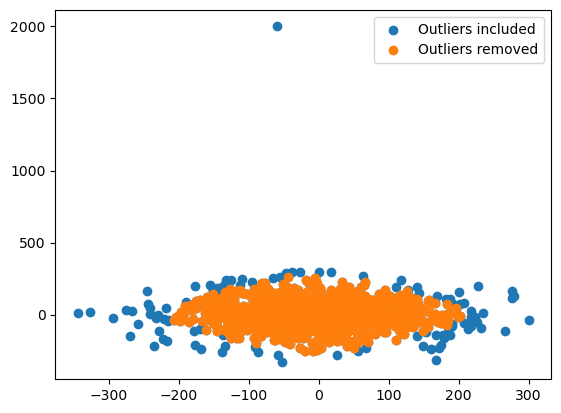

In [127]:
# Create 2 numpy arrays of random number normally distributed
A = np.random.randn(1000) * 100
B = np.random.randn(1000) * 100
# To guarantee at least one outlier
# Randomly assign one element of B to be too big
B[np.random.randint(1000)] = 2000

fig, ax = plt.subplots()
[a,b] = remove_outliers_cooks(A,B)
ax.scatter(A,B, label = 'Outliers included')
ax.scatter(a,b, label = 'Outliers removed')
ax.legend()

# Linear Regression
https://realpython.com/linear-regression-in-python/ 

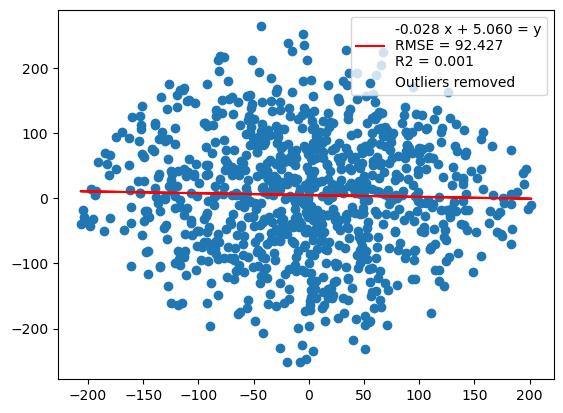

In [131]:
a_ = a.reshape(-1,1)
regression_model = LinearRegression()
  
# Fit the data(train the model)
regression_model.fit(a_, b)
  
# Predict
y_predicted = regression_model.predict(a_)
  
# model evaluation
mse=mean_squared_error(b,y_predicted)

# Root mean squared error
rmse = np.sqrt(mean_squared_error(b, y_predicted))
# R^2
r2 = r2_score(b, y_predicted)

# Strings of slope intercept, RMSE, and R^2
cff = "%.3f" % regression_model.coef_
intcpt = "%.3f" % regression_model.intercept_
RMSE = "%.3f" % rmse
R2 = "%.3f" % r2
   
fig, ax = plt.subplots()
lbl = cff + ' x + ' + intcpt + ' = y\nRMSE = ' + RMSE + '\nR2 = ' + R2
ax.plot(a_, y_predicted, color = 'red', label = lbl)
ax.scatter(a,b, label = 'Outliers removed')
ax.legend()

# Least squares polynomial fit
https://numpy.org/doc/stable/reference/generated/numpy.polyfit.html

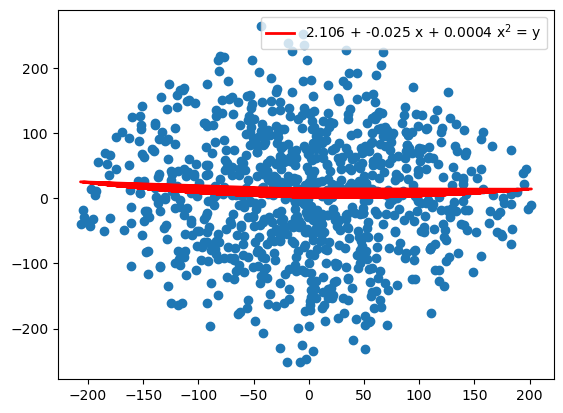

In [152]:
fig, ax = plt.subplots()
px = np.poly1d(np.polyfit(a, b, 2))
sols = px[0] + px[1] * a + px[2] * a**2 

p0 = "%.3f" % px[0]
p1 = "%.3f" % px[1]
p2 = "%.4f" % px[2]
lbl = p0 + ' + ' + p1 + ' x + ' + p2 + ' x$^2$'  + ' = y'
ax.plot(a,sols, 'r', lw = 2, zorder = 3, label = lbl)
ax.scatter(a, b)
ax.legend()

# Create `xarray` dataset
The goal here is to make a dataset similar to model output datasets. Model outputs are usually NetCDF files, and `xarray` deals with NetCDF very well. The dataset needs dimensions for time, latitude, and longitude. It would also be possible to add a depth dimension, but I opted to keep this "surface." After assigning dimensions, I create variables within the dataset. The variables are given the same dimensions as the overall dataset. I created filler data for the variables in the shape of the dataset. It is easy to make an array of any shape using `numpy.random.randn`, but I prefer to fill my dataset with NaN values, so I replaced all the random values with Nan. Then, one could loop through this dataset and assign values at each coordinate point. That takes awhile, but it makes a very easy to use dataset. 

Xarray Dataset: https://docs.xarray.dev/en/stable/generated/xarray.Dataset.html

Xarray Variable: https://docs.xarray.dev/en/stable/generated/xarray.Variable.html#xarray.Variable

Creating the time dimension with type of datetime was a new challenge. I used `pandas.date_range()`.

https://pandas.pydata.org/docs/reference/api/pandas.date_range.html

In [182]:
dd = xr.Dataset()
T = pd.date_range("1850-01-15", freq = 'M', periods=2040)
y = np.arange(-89.5,90,1)
x = np.arange(0.5,360,1)
dd = dd.assign_coords({'t': T, 'lat': y, 'lon': x})
dat = np.random.randn(len(T), len(y), len(x))
dat[:] = np.nan
dd['fCO2'] = xr.Variable(dims = ['t', 'lat', 'lon'], data = dat, 
                         attrs= {'Description': 'fugacity', 
                                'units': 'µatm'})
dd['Omega'] = xr.Variable(dims = ['t', 'lat', 'lon'], data = dat, 
                         attrs= {'Description': 'Aragonite saturation state', 
                                'units': 'unit'})
dd['pH'] = xr.Variable(dims = ['t', 'lat', 'lon'], data = dat, 
                      attrs= {'Description': 'pH', 
                                'units': 'total pH scale'})
dd

<xarray.Dataset>
Dimensions:  (t: 2040, lat: 180, lon: 360)
Coordinates:
  * t        (t) datetime64[ns] 1850-01-31 1850-02-28 ... 2019-11-30 2019-12-31
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
Data variables:
    fCO2     (t, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan nan
    Omega    (t, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan nan
    pH       (t, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan nan

In [183]:
dd.pH

<xarray.DataArray 'pH' (t: 2040, lat: 180, lon: 360)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
  * t        (t) datetime64[ns] 1850-01-31 1850-02-28 ... 2019-11-30 2019-12-31
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
Attributes:
    Description:  pH
    units:        total pH scale

# Create `pandas` DataFrame and calculate discrete distance with `numpy.diff()`

I want this to be similar to a time series, so I have a column with datetime information (hourly frequency) and a column with random data. 

Frequency information for datetime ranges: https://pandas.pydata.org/docs/user_guide/timeseries.html#timeseries-offset-aliases

Numpy diff: https://numpy.org/doc/stable/reference/generated/numpy.diff.html

Time zone handling: https://pandas.pydata.org/docs/user_guide/timeseries.html#time-zone-handling

Pandas dataframe: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html

Pandas dataframe renaming: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.rename.html

In [191]:
time = pd.date_range("2023-01-01 00:00:00", freq = 'H', periods=100).tz_localize("US/Eastern")
data = np.random.randn(len(time))

temp = {'Time': time, 
        'Data': data}

df = pd.DataFrame(temp)
df

,Time,Data
0,2023-01-01 00:00:00-05:00,-1.209109
1,2023-01-01 01:00:00-05:00,-0.853991
2,2023-01-01 02:00:00-05:00,0.113624
3,2023-01-01 03:00:00-05:00,1.249700
4,2023-01-01 04:00:00-05:00,-1.621459
...,...,...
95,2023-01-04 23:00:00-05:00,-2.371703
96,2023-01-05 00:00:00-05:00,0.252219
97,2023-01-05 01:00:00-05:00,-0.829222
98,2023-01-05 02:00:00-05:00,0.007419


In [194]:
deldf = df.diff()
deldf = deldf.rename(columns={"Time": "∆Time", "Data": "∆Data"})
deldf

,∆Time,∆Data
0,NaT,NaN
1,0 days 01:00:00,0.355118
2,0 days 01:00:00,0.967615
3,0 days 01:00:00,1.136077
4,0 days 01:00:00,-2.871159
...,...,...
95,0 days 01:00:00,-1.494864
96,0 days 01:00:00,2.623922
97,0 days 01:00:00,-1.081441
98,0 days 01:00:00,0.836641
